---- MODEL'S OBJECTIVES AND PARTS ---- <br><br>
The overall objective of this model is to decide whether to make an underlying asset a part of Call Debit Spread portfolio, i.e., what are the probabilities of profit and loss of the asset itself?

The idea/hypothesis beyond this model is as follows: If Call Debit Spread's long call and short call options' strike prices are above underlying asset's price at time t but still within the 95% confidential boundary for time t + 1, i.e., the price of an underlying asset ..... need to finish this idea.
 
The log-normal distribution of geometric Brownian motions is skewed, but it's skewness isn't significant during the early GBM paths' steps. If these GBMs represent an underlying asset's prices

---- Objectives on future predictions/modelling using only geometric Brownian motions, i.e., drift and variance from historical data on the day of modelling ----
1. Simulating future moves of an underlying asset using geometric Brownian motions.
2. Calculating proxy prices and percentual P&Ls of all Call Debit Spreads for all GBM paths/simulations and all their time steps till expiration.
3. Considering a specific time window, e.g., first 100 days, of Call Debit Spread lifespan and calculating the expected return/loss when a Call Debit Spread is closed at particular percentual profit or loss threshold.
4. Considering the left Call Debit Spreads throughout all GBM simulations which haven't been closed due to hitting the particular percentual P&L within the specified time window and as drift and variance should have already taken an effect, first-passage problem for particular percentual loss is addressed.
5. Using Monte Carlo simulation, simulating opening various Call Debit Spreads and their closing based on previously defined conditions. The product is expected return/loss based on max profits/losses of Call Debit Spreads available.
6. Optimizing thresholds of specific time window, percentual profit and losses within this time window. Different lifespan lenghts of options are also tested. Done numerically at this moment.

---- Objectives on historical data -> back_testing.ipynb file ----<br>
The previous modelling was made on geometric Brownian motions simulation based on drift and variance from historical data on the day of modelling without considering where the price of an underlying asset is and what are the other conditions on the market. This part is to back-test the strategy on historical data, given the particular condition under which the Call Debit Spread is opened.
1. Starting with considering particular levels of Moving Averages and underlying asset's price, defining when Call Debit Spread position would be opened. Based on 95% confidential interval, set of possible Call Debit Spreads is made and since that day, prices and percentual P&Ls are calculated for every spread for the following X years.
2. Using the conditions and thresholds defined in the future predictions/modelling part for closing lossing and profitable positions, Monte Carlo simulation is run on dates meeting the open-position conditions and on-these-dates available spreads to simulate the expected return on the real historical data.

---- Additional Modelling Ideas ----
1. Creating set of lossing and profitable Call Debit Spreads by opening spreads on every day on historical data and closing it according to defined conditions and on defined threshold, researching values of quantitative parameters and their combination and significant scores in the model that define profitable or lossing spreads.
2. Researching effect of sentiment

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Math
from ib_insync import *
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
#import config
import random
from alpha_vantage.timeseries import TimeSeries
from scipy.stats import lognorm
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import inspect
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
from scipy.stats import normaltest
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta

# Warnings caused by differences/changes in future Python's libraries are off
import warnings
warnings.simplefilter("ignore", category=UserWarning)

MODELLING CONSTANTS

In [2]:
YEARS_TO_EXP = 2
PREMATURE_PERC_PROFIT = 0.35
PREMATURE_PERC_LOSS = -0.5

Reason for price path prediction model: 

!!! I nedd to verify how robust this model is in terms of ignoring outlying values.

In [3]:
class ModelARIMA():

      def __init__(self) -> None:
            pass

      def hyndman_khandakar(self, series):
            auto_model = auto_arima(series)
            #forecast, conf_int = auto_model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
            #conf_int = conf_int[0]
            order = list(auto_model.order)
            seasonal_order = list(auto_model.seasonal_order)
            parameters = []
            parameters.append(order)
            parameters.append(seasonal_order)
            return parameters
      
      def check_stationarity(self, data):
            result = adfuller(data)
            if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
                  return True
            else:
                  return False
        
      def invert_differencing(self, forecast, differencing_count, data):
            reverted = forecast
            for i in range(1, differencing_count + 1):
                  reverted = reverted.cumsum() + data["Close"].iloc[-i]
            return reverted

      def arima_model(self, series, parameters):
            order = tuple(parameters[0])
            seasonal_order = tuple(parameters[1])
            model = sm.tsa.statespace.SARIMAX(series, order=order, seasonal_order=seasonal_order, trend="c")
            res = model.fit(disp=False)
            forecast = res.get_prediction(steps=1)
            expected = forecast.predicted_mean.values[0]
            conf_int = forecast.conf_int(alpha=0.05).values.tolist()[0]
            return expected, conf_int

      def get_parameters(self, data):
            close_p = data["Close"]

            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  is_data_stationary = self.check_stationarity(close_p)

            parameters = self.hyndman_khandakar(close_p)
            return parameters
      
      def model(self, data, parameters):
            data = data.sort_values(by="Date", ascending=True)
            close_p = data["Close"]
            differencing_count = 0
            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  differencing_count += 1
                  is_data_stationary = self.check_stationarity(close_p)

            forecast, conf_int = self.arima_model(close_p, parameters)

            conf_int = np.array(conf_int, ndmin=2)  
            forecast = pd.Series(forecast)

            forecast = self.invert_differencing(forecast, differencing_count, data)
            conf_int[:, 0] = self.invert_differencing(conf_int[:, 0], differencing_count, data)
            conf_int[:, 1] = self.invert_differencing(conf_int[:, 1], differencing_count, data)

            return forecast, conf_int
      

BLACK-SCHOLES MODEL:

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

where

$$
d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

CALL OPTION THETA:

$$
\theta_{\text{call}} = -\frac{S_0 N'(d_1) \sigma}{2\sqrt{T}} - rK e^{-rT} N(d_2)
$$

CALL DEBIT SPREAD THETA:

$$
\theta_{\text{Call Debit Spread}} = \theta_{\text{Long Call}} - \theta_{\text{Short Call}}
$$

or

$$
\theta_{\text{Call Debit Spread}} = 
\left(
-\frac{S_0 N'(d_1^{(L)} \sigma)}{2\sqrt{T}} 
- rK_L e^{-rT} N(d_2^{(L)})
\right)
-
\left(
-\frac{S_0 N'(d_1^{(S)}) \sigma}{2\sqrt{T}} 
- rK_S e^{-rT} N(d_2^{(S)})
\right)
$$

In [4]:
def calculate_call_option_price(S, K, sigma, T, r):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)      
    return call_price

def calculate_call_option_theta(S, K, sigma, T, r):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    first_term = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
    second_term = - r * K * np.exp(-r * T) * norm.cdf(d2)
    theta = first_term + second_term # Time decay
    return theta

APPROXIMATING IMPLIED VOLATILITY

The value of Implied Volatility (IV, i.e., future volatility expectation) is constantly being determined by market forces and it can be found numericaly via Black-Scholes model. However, since I don't have historical option prices either, I can approximate IV using historical realized volatility.<br><br>

$$
\sigma_{historical} = \sqrt{\frac{252}{N} \sum_{i=1}^{N} (\ln(\frac{S_i}{S_{i-1}}))^2}
$$

where

$N$ = number of trading days in the historical window and 252 days is used for annualization of the volatility $\newline$
$S_i$ = stock price on day i $\newline$
$\sigma_{historical}$ = historical volatility as a proxy for implied volatility

Logarithmic returns measure the percentage change in the stock price between two consecutive periods, e.g., days. Relative change expressed by the fraction is transformed into more symmetric measure via natural logarithm.

In [5]:
def calculate_historical_volatility(histrorical_volatility_data):
    sum_squared_returns = histrorical_volatility_data["log_returns_squared"].sum()
    n = histrorical_volatility_data["log_returns"].count()
    sigma_historical = np.sqrt((252 / n) * sum_squared_returns)
    return round(sigma_historical, 6)

In [87]:
data = pd.read_csv("./../data/qqq_data.csv")
data["Date"] = pd.to_datetime(data["Date"])
#type(data["Date"][0])
#one_year_ago = pd.Timestamp.now(tz="America/New_York") - pd.Timedelta(days=365)
one_year_ago = pd.Timestamp.now() - pd.Timedelta(days=365)
last_year_data = data[data["Date"] >= one_year_ago]
last_year_data

,Unnamed: 0,Date,Open,High,Low,Close,Volume,50_day_MA,100_day_MA,Log_return,Volatility,Risk-free Rate
2265,2265,2024-08-16,472.62,476.4100,471.650,475.03,38383623.0,473.3652,457.1918,0.001285,0.311300,0.0389
2266,2266,2024-08-19,475.17,481.3100,473.370,481.27,23737674.0,473.7232,457.5713,0.013050,0.310263,0.0386
2267,2267,2024-08-20,480.35,482.9400,478.550,480.26,29209340.0,474.0692,457.9256,-0.002101,0.310095,0.0382
2268,2268,2024-08-21,481.05,484.3700,479.320,482.50,25658787.0,474.4226,458.3105,0.004653,0.278683,0.0379
2269,2269,2024-08-22,484.84,485.5400,473.810,474.85,37739576.0,474.5592,458.6095,-0.015982,0.282254,0.0386
...,...,...,...,...,...,...,...,...,...,...,...,...
2508,2508,2025-08-07,571.67,573.3200,565.110,569.24,44462972.0,546.9804,512.4310,0.003379,0.122263,0.0423
2509,2509,2025-08-08,570.45,574.7700,570.150,574.55,35255472.0,548.0932,513.3488,0.009285,0.124742,0.0427
2510,2510,2025-08-11,574.69,576.8000,571.570,572.85,33112917.0,549.1516,514.3319,-0.002963,0.125656,0.0427
2511,2511,2025-08-12,575.16,580.3500,572.485,580.05,42271441.0,550.3704,515.3235,0.012490,0.131553,0.0429


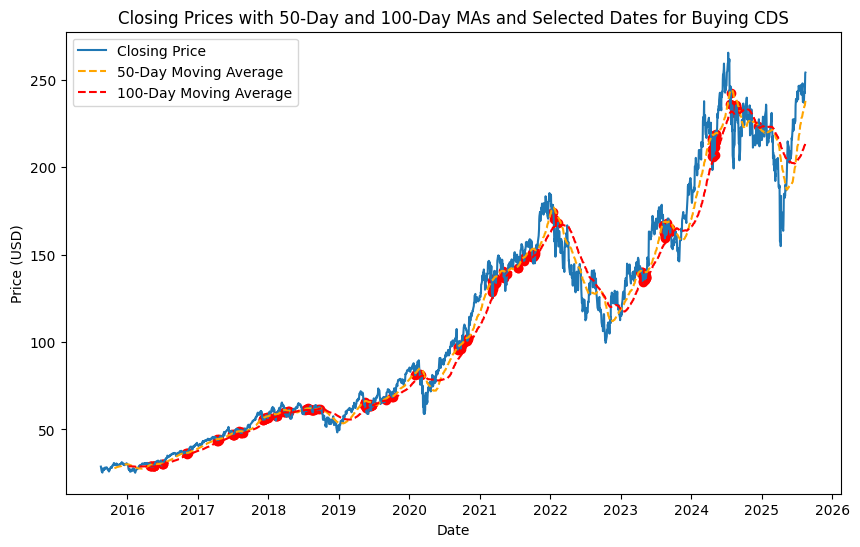

In [6]:
data = pd.read_csv("./../data/soxx_data.csv")

data["Date"] = pd.to_datetime(data["Date"])
one_year_ago = pd.Timestamp.today() - pd.Timedelta(days=365)
last_year_data = data[data["Date"] >= one_year_ago]

# These are the selected dates only for the visualisation on the following chart
selected_dates = data[
    (data["50_day_MA"] > data["100_day_MA"]) &
    (data["Close"] > data["100_day_MA"]) &
    (data["Close"] < data["50_day_MA"])
]

# Selected dates for the strategy back-testing must end at least X days (equal to time to expiration T) 
# before the last day in the dataset, so P&Ls during the spreads' lifespan can be computed
selected_dates_backtest = \
data[
    (data["Date"] <= (data["Date"].iloc[0] - timedelta(days=YEARS_TO_EXP * 365))) &
    (data["Date"] > (data["Date"].iloc[-1] + timedelta(days=30))) &
    (data["50_day_MA"] > data["100_day_MA"]) &
    (data["Close"] > data["100_day_MA"]) &
    (data["Close"] < data["50_day_MA"])
]

# Visualisation of risky asset's time series, moving averages, and call debit spread events
plt.figure(figsize=(10, 6))
plt.plot(data["Date"], data["Close"], label="Closing Price")
plt.plot(data["Date"], data["50_day_MA"], label="50-Day Moving Average", color="orange", linestyle="--")
plt.plot(data["Date"], data["100_day_MA"], label="100-Day Moving Average", color="red", linestyle="--")
plt.scatter(selected_dates["Date"], selected_dates["Close"], color="r", marker="o")
plt.title(f"Closing Prices with 50-Day and 100-Day MAs and Selected Dates for Buying CDS")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [23]:
model = ModelARIMA()
parameters = model.get_parameters(data)
parameters

[[3, 0, 2], [0, 0, 0, 0]]

DEBIT CALL SPREAD

Debit Call Spread is an option strategy when Call option with lower strike price is bought while the Call option on the same asset and same expiration date with higher strike price is written.

– Max loss of a Call Debit Spread is given by the premium paid for the spread: $$\text{Max Loss} = \text{Premium Paid for the Long Call (lower call)} - \text{Premium Received for the Short Call (higher strike)} = \text{Net Premium Paid}$$

– Max profit of a Call Debit Spread is given by the difference between the strike prices minus the net premium paid: $$\text{Max Profit} = \text{(Short Call strike - Long Call strike)} - \text{Net Premium Paid}$$

– Profit/Loss at expiration under the scenario that asset's price at expiration is equal to or higher than strike price of bought call option and lower than strike price of written call option is given by the deduction of bought option strike price from asset's price at expiration minus Net Premium Paid: $$\text{P/L under } K_1 <= S_T < K_2 \text{ scenario } = (S_T - K_1) - \text{Net Premium Paid}$$

Before expiration, beyond options' intrinsic value described above, spread value is influenced by options' extrinsic values – time decay (Theta), implied volatility (Vega), and interest rates (Rho) – as well. The call debit spread value is given by prices of call options it consists of.

..........
..........

PROGRAM FLOW:

selected_dates – considering the 1 year expiration, selected dates are a series of trading days starting today minus 1 year

Iteration through selected_dates. For each selected date, derive ATM strike price from at that time asset's trading price and build an option chain (set of options with various strike prices) containing options with strike prices by 1 USD on both sides, OTM and ITM, from ATM strike price. The last OTM and ITM options are given by 95% confidential boundaries of prediction produced by ARMA model for asset's prices for the last year before selected date. Price of each call option is calculated via Black-Scholes model and proxy of Implied Volatility. All possible Call Debit Spreads are created.

OBJECTIVES:
1. For all Call Debit Spreads existing within the 95% confidential boundaries, calculate probability of P/L at the expiration date (in 1 year).
2. For all Call Debit Spreads existing within the 95% confidential boundaries, calculate probability of achieving 60% of max profit before
   expiration.
3. What Call Debit Spreads – with what strikes – have the highest probability of profit.

SHORTCOMINGS:

Prices of historical options aren't the actual prices as they were at that time. Prices are obtained via Black-Scholes model using historical volatility calculated from asset's prices following after the date for which the proxy of implied volatility is calculated. Even though this
makes the expected volatility accurate (actual volatility is used), it's different from the expectation at that time, so the call options are
misspriced. Moreover, this way, prices of all options in an option chain for one date are calculated using the same proxy of IV, while in reality, implied volatilities differ for various strike prices.
This inaccuracy can be addressed by using actual historical option prices from Alphavantage API.

In [24]:
# ---- CREATING CALL DEBIT SPREADS AND PRICING THEM ----
forecast, conf_int = model.model(data, parameters)

strike_list_lower_boundary = round(round(conf_int[0][0]))
strike_list_upper_boundary = round(round(conf_int[0][1]))
strike_prices_list = [strike for strike in range(strike_list_lower_boundary, strike_list_upper_boundary + 1)]

# Historical volatility as a proxy of implied volatility for a particular historical date on which we want to
# compute option price is calculated on data since that date to presence
historical_volatility_data = data[
    (data["Date"] <= data["Date"].iloc[-1]) & 
    (data["Date"] >= data["Date"].iloc[-1] - pd.DateOffset(years=1))
].sort_values(by="Date", ascending=True)
historical_volatility_data["log_returns"] = np.log(historical_volatility_data["Close"] / historical_volatility_data["Close"].shift(1))
historical_volatility_data["log_returns_squared"] = historical_volatility_data["log_returns"]**2
sigma_historical = calculate_historical_volatility(historical_volatility_data)
#print(sigma_historical)

strike_price_chain = {}
strike_price_chain = {
    "strike": strike_prices_list,
    "price": np.full(len(strike_prices_list), None),
    "theta": np.full(len(strike_prices_list), None),
    "implied_volatility": np.full(len(strike_prices_list), sigma_historical) #last_year_data["Volatility"].iloc[-1]
}

strike_price_chain = pd.DataFrame(strike_price_chain)

# Calculating price of options in a strike price chain
strike_price_chain["price"] = strike_price_chain.apply(
    lambda row: pd.Series(
        calculate_call_option_price(
            data["Close"].iloc[-1],  # Stock price (scalar)
            row["strike"],  # Strike price (scalar)
            row["implied_volatility"],  # Implied volatility (scalar)
            YEARS_TO_EXP,  # Time to exercise two years
            data["Risk-free Rate"].iloc[-1]  # Risk-free rate adjusted to ratio of 1 as implied volatility
            )
    ),
    axis=1
)

# From a strike price chain, set of Call Debit Spread is created and inserted into spreads DataFrame
spreads = []
for i, long_call in strike_price_chain.iterrows():
    for j, short_call in strike_price_chain.iloc[i+1:].iterrows():
        spread_cost = long_call["price"] - short_call["price"]
        max_profit = (short_call["strike"] - long_call["strike"]) - spread_cost # !!!! This doesn't seem to be correct
        #theta = long_call["theta"] - short_call["theta"]

        spreads.append({
            "date": data["Date"].iloc[-1],
            "expiration_date": data["Date"].iloc[-1] + pd.DateOffset(years=2),
            "long_strike": long_call["strike"],
            "short_strike": short_call["strike"],
            "long_price": long_call["price"],
            "short_price": short_call["price"],
            "spread_cost": spread_cost,
            "max_profit": max_profit,
            "max_loss": spread_cost,
            #"theta": theta,
            "expiration_p/l": None,
            "%_profit": None,
            "trading_days": None
        })

spreads = pd.DataFrame(spreads)

spreads = spreads[
    (spreads["long_strike"] < spreads["short_strike"]) &
    # Strike of short strike is above current underlying asset price
    (spreads["short_strike"] > data["Close"].iloc[-1])
]

spreads = spreads[(spreads["max_profit"] > spreads["max_loss"])]

spreads

,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,%_profit,trading_days
5,2025-08-14,2027-08-14,249,255,67.260380,64.757647,2.502733,3.497267,2.502733,None,None,None
6,2025-08-14,2027-08-14,249,256,67.260380,64.349435,2.910945,4.089055,2.910945,None,None,None
7,2025-08-14,2027-08-14,249,257,67.260380,63.943737,3.316643,4.683357,3.316643,None,None,None
8,2025-08-14,2027-08-14,249,258,67.260380,63.540539,3.719841,5.280159,3.719841,None,None,None
9,2025-08-14,2027-08-14,249,259,67.260380,63.139830,4.120550,5.879450,4.120550,None,None,None
10,2025-08-14,2027-08-14,249,260,67.260380,62.741597,4.518783,6.481217,4.518783,None,None,None
15,2025-08-14,2027-08-14,250,255,66.836832,64.757647,2.079185,2.920815,2.079185,None,None,None
16,2025-08-14,2027-08-14,250,256,66.836832,64.349435,2.487397,3.512603,2.487397,None,None,None
17,2025-08-14,2027-08-14,250,257,66.836832,63.943737,2.893095,4.106905,2.893095,None,None,None
18,2025-08-14,2027-08-14,250,258,66.836832,63.540539,3.296293,4.703707,3.296293,None,None,None


FUTURE MODELLING OBJECTIVE 1:<br> SIMULATING FUTURE MOVES OF AN UNDERLYING ASSET USING GEOMETRIC BROWNIAN MOTIONS

If a stock price S follows a geometric Brownian Motion 

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

then the solution at maturity is:

$$
S_T = S_0 \exp\left( \left( \mu - \frac{1}{2} \sigma^2 \right) T + \sigma W_T \right)
$$

However, it gives us value only for one stock price at maturity, so if we want to get to probability of $S_T$ > K, we need to simulate multiple possible future prices (run this formula many times with different random values for $W_T$). Terminal values $S_T$ from multiple simulation runs of a geometric Brownian motion are log-normally distributed.

$$
\ln(S_T) \sim \mathcal{N} \left( \ln(S_0) + \left( \mu - \frac{\sigma^2}{2} \right) T, \, \sigma^2 T \right)
$$

Although the probability of $S_T$ > K calculated under the risk-neutral assumption (using risk-free rate) would give us lower probability than using the real-world expected return (investors demand risk premium therefore the chances that stock price at expiration is higher than strike price are grater), thus it would be more conservative, it can also highly underestimate the outcomes and cost us finding a profitable strategy. It doesn't model real-world, but the arbitrage-free frictionless market. Therefore, $\mu$ (drift/expected return) is found in the first stage. 


In [25]:
# ---- GEOMETRIC BROWNIAN MOTION SIMULATION ----

T = YEARS_TO_EXP # time in years
n = 252 * T # number of steps in trading days per year
M = 110 # number of simulations
S0 = last_year_data["Close"].iloc[-1] # initial asset price
mu = np.mean(last_year_data["Log_return"]) * 252 # Drift
sigma = np.std(last_year_data["Log_return"], ddof=1) * np.sqrt(252)
dt = T/n # calculate each time step

# simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M, n)).T
)

# include array of 1's
St = np.vstack([np.ones(M), St])

# multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0)
St = S0 * St.cumprod(axis=0)

# Define time interval correctly
time = np.linspace(0, T, n+1)

# Require numpy array that is the same shape as St -> time matrix tt[i, j] for i-th step and j-th simulation
tt = np.full(shape=(M, n+1), fill_value=time).T


# ---- LOG-NORMAL DISTRIBUTION OF S_T's SIMULATED VIA GEOMETRIC BROWNIAN MOTION ----
mean_ln = np.log(S0) + (mu - 0.5 * sigma**2) * T
std_ln = sigma * np.sqrt(T)
K = 610

# Log-normal distribution
s = np.linspace(0.01, S0 * 4, 1000)
pdf = lognorm.pdf(s, s=std_ln, scale=np.exp(mean_ln))

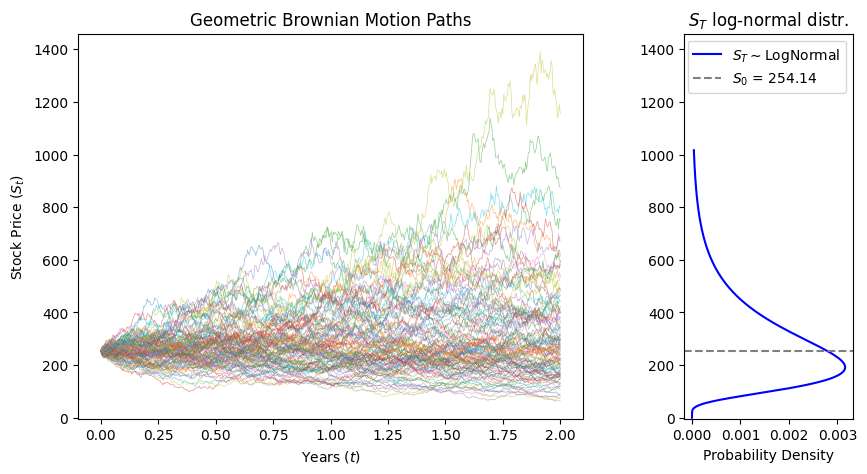

In [26]:
# ---- GBM SIMULATION & LOG-NORM. DISTR. VISUALISATION ----

# Plotting
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3)

# GBM plotting
ax0 = fig.add_subplot(gs[0])
ax0.plot(tt, St, lw=0.5, alpha=0.5)
ax0.set_xlabel("Years $(t)$")
ax0.set_ylabel("Stock Price $(S_t)$")
ax0.set_title("Geometric Brownian Motion Paths")

# Histogram of S_T
ax1 = fig.add_subplot(gs[1])
ax1.plot(pdf, s, label=r'$S_T \sim \mathrm{LogNormal}$', color='blue')
ax1.set_title("$S_T$ log-normal distr.")
ax1.axhline(S0, linestyle='--', color='gray', label=f"{r'$S_0$'} = {S0}")
#ax1.axhline(K, linestyle="-.", color="red", label=f"K = {K}")
ax1.legend()
ax1.set_xlabel("Probability Density")


min_price, max_price = ax0.get_ylim()
ax1.set_ylim(min_price, max_price)

plt.tight_layout()
plt.show() 


In [27]:
St

array([[254.14      , 254.14      , 254.14      , ..., 254.14      ,
        254.14      , 254.14      ],
       [257.06471009, 254.39630474, 251.90899056, ..., 252.91874103,
        260.5694935 , 257.07901594],
       [262.39865644, 252.74761224, 245.01769543, ..., 259.05758449,
        249.52316523, 253.92880336],
       ...,
       [295.60770103, 247.03907041, 624.72763343, ..., 574.9452617 ,
        207.36289681, 284.63876853],
       [312.02728393, 251.52456381, 599.59717024, ..., 573.76590069,
        214.51325185, 281.44891006],
       [319.07064711, 252.55645652, 594.96013789, ..., 581.61433574,
        226.50649215, 278.80141388]])

FUTURE MODELLING OBJECTIVE 2:<br>
CALCULATING PROXY PRICES AND PERCENTUAL P&Ls OF ALL CALL DEBIT SPREADS FOR ALL GEOMETRIC BROWNIAN MOTION PATHIS/SIMULATIONS AND ALL THEIR TIME STEPS TILL THE EXPIRATION

Before considering a specific time window within Call Debit Spreads' lifespan for shortening the time for which the position is kept open to accelerate positions turnover and increasing a profit potentionally – it will be tested – Monte Carlo simulation is used to approximate the expected profit on spreads if they are kept till expiration and exercised if profitable, so the result can be compared with simulation made on the assumption of closing positions prematurely based on conditions. 

In [28]:
# ---- COMPUTING PROXY OF IMPLIED VOLATILITIES FROM THE SIMULATED HISTORICAL PRICES ----
asset_prices_paths = St.T

# Length of nested array, i.e., number of days to expiration excl. S0
n_days = asset_prices_paths.shape[1] - 1

n_spreads = len(spreads)

all_sim_volatilities = []

for path in asset_prices_paths:
    prices = path[1:]
    sim_step_vol = np.zeros((n_days, n_spreads))

    #print(len(prices))

    step = 0
    for t in range(n_days):

        series = path[1:t]
        if len(series) > 365:
            series = path[i-365:t]
        elif len(series) < 365:
            diff = 365 - len(series)
            series = np.concatenate([
                data["Close"][-diff:].to_numpy(),
                path[1:t]   
            ])
        else:
            pass
        series = pd.Series(series)
        vol_data = pd.DataFrame()
        vol_data["log_returns"] = np.log(series / series.shift(1))
        vol_data["log_returns_squared"] = vol_data["log_returns"]**2
        step_sigma = calculate_historical_volatility(vol_data)
        sim_step_vol[t] = step_sigma
        step += 1

    all_sim_volatilities.append(sim_step_vol)




In [29]:
# ---- COMPUTING PRICES AND P&Ls OF SPREADS DURING THEIR LIFE TIME (FUTURE MODELLING) ----

# Converting spreads to arrays of strike prices of long and short options
long_strikes = spreads["long_strike"].values
short_strikes = spreads["short_strike"].values
spread_costs = spreads["spread_cost"].values
n_spreads = len(spreads)

asset_prices_paths = St.T
# Length of nested array, i.e., number of days to expiration excl. S0
n_days = asset_prices_paths.shape[1] - 1
# Array of fractions of year giving time to expiration for every day
time_to_expiration = (n_days - np.arange(n_days)) / 252

#sigma = data["Volatility"][0]
r = data["Risk-free Rate"].iloc[-1]

all_spreads_prices_excluding_s0_and_sT = []
all_spreads_pnls_excluding_s0_and_sT = []

# For each GBM price path, i.e., for each simulation
for ith_path, path in enumerate(asset_prices_paths):
    prices = path[1:] # Excluding S_0
    # Empty arrays where each nested array represents spreads and there is as many as them as days on
    # simulated price paths produced by GBM
    spread_prices = np.zeros((n_days, n_spreads))
    spread_pnls = np.zeros((n_days, n_spreads))

    # We go day by day, getting daily prices and calculating prices of long and short options using
    # constant sigma and risk-free rate for simplicity and consistency, calculating the option spreads'
    # value and percentual p&l on that day and adding it into nested arrays, on time t, representing 
    # spreads' prices and p&ls for each time step on GBM
    for t in range(n_days):
        S_t = prices[t]
        T = time_to_expiration[t]
        sigma = all_sim_volatilities[ith_path][t]
        long_call_prices = np.array([calculate_call_option_price(S_t, K1, sig, T, r) for K1, sig in zip(long_strikes, sigma)])
        short_call_prices = np.array([calculate_call_option_price(S_t, K2, sig, T, r) for K2, sig in zip(short_strikes, sigma)])
        spread_values = long_call_prices - short_call_prices
        spread_returns = (spread_values - spread_costs) / spread_costs
        spread_prices[t] = spread_values
        spread_pnls[t] = spread_returns

    all_spreads_prices_excluding_s0_and_sT.append(spread_prices)
    all_spreads_pnls_excluding_s0_and_sT.append(spread_pnls)
    
  

In [30]:
# ---- WHAT SPREADS ARE/AREN'T (1/-1) PROFITABLE AT EXPIRATION ----

final_prices = np.array(St[-1])[:, np.newaxis]
short_strikes = spreads["short_strike"].to_numpy()
long_strikes = spreads["long_strike"].to_numpy()
spread_costs = spreads["spread_cost"].to_numpy()
max_profits = spreads["max_profit"].to_numpy()

spreads_pnls_at_exp = np.where(final_prices >= short_strikes, max_profits,
                          np.where(final_prices <= long_strikes, -spread_costs,
                                   final_prices - long_strikes - spread_costs
                                   )
                          )

# (1) max profit, i.e., price >= short strike
spreads_pnls_at_exp_scenarios = np.where(final_prices >= short_strikes, 1,
                                    # (-1) max loss, i.e., price <= long strike OR (0) partial P&L  
                                    np.where(final_prices <= long_strikes, -1, 0)
                                )

# Percentual P&L at expiration
spreads_perc_pnls_at_exp = spreads_pnls_at_exp / spread_costs


In [31]:
# ---- ADDING LAST TIME STEP, I.E., DAY OF EXPIRATION TO GBM PATHS OF SIMULATED P&Ls OF SPREADS ----
sppat_expanded = spreads_perc_pnls_at_exp[:, np.newaxis, :]
spreads_perc_pnls_at_exp_complete = np.concatenate((all_spreads_pnls_excluding_s0_and_sT, sppat_expanded), axis=1)

In [32]:
# ---- DROPPING DUPLICATED AT-EXPIRATION STEP PRODUCED BY BLACK-SCHOLES FORMULA ----
# Last two time steps are basically same – penultimate one is product of Black-Scholes formula while
# the last one was computed by algebraic formulas for events at expiration. The results are very similar,
# so the one produced algebraicly is kept and the one produced by BS formula is dropped.
spreads_perc_pnls_at_exp_final = np.concatenate(
    (spreads_perc_pnls_at_exp_complete[:, : -2], spreads_perc_pnls_at_exp_complete[:, -1:]), axis=1
)

In [33]:
# As 0s in spreads_pnls_at_exp_scenarios indicates partial profits and losses, i.e., asset's price
# at expiration is between short and long strike, these partial P&L spreads are isolated
max_profit_at_exp = spreads_pnls_at_exp_scenarios[spreads_pnls_at_exp_scenarios == 1]
max_loss_at_exp = spreads_pnls_at_exp_scenarios[spreads_pnls_at_exp_scenarios == -1]
partial_profit_loss = spreads_perc_pnls_at_exp[spreads_pnls_at_exp_scenarios == 0]
partial_loss_at_exp = partial_profit_loss[partial_profit_loss < 0]
partial_profit_at_exp = partial_profit_loss[partial_profit_loss > 0]
all_events = len(max_profit_at_exp) + len(max_loss_at_exp) + len(partial_profit_at_exp) +\
len(partial_loss_at_exp)

print("""
These probabilities are the unconditional one and they say us only the likelihood of asset's
price being higher or lower than short strike price or long strike price, respectively, or
whether the asset's price at expiration appears between short strike and long strike prices.
      
The spread between short strike and long strike isn't considered here as well as the size of
maximum profit and maximum loss, so the expected return doesn't have to be symmetric
with these probabilities, i.e., max profit might be smaller monetarily than the max loss.
""")
print(f"Probability of achieving max profit: {round((len(max_profit_at_exp) / all_events), 4)}")
print(f"Probability of achieving max loss: {round((len(max_loss_at_exp) / all_events), 4)}")
print(f"Probability of partial profit: {round((len(partial_profit_at_exp) / all_events), 4)}")
print(f"Probability of partial loss: {round((len(partial_loss_at_exp) / all_events), 4)}")



These probabilities are the unconditional one and they say us only the likelihood of asset's
price being higher or lower than short strike price or long strike price, respectively, or
whether the asset's price at expiration appears between short strike and long strike prices.
      
The spread between short strike and long strike isn't considered here as well as the size of
maximum profit and maximum loss, so the expected return doesn't have to be symmetric
with these probabilities, i.e., max profit might be smaller monetarily than the max loss.

Probability of achieving max profit: 0.5185
Probability of achieving max loss: 0.4674
Probability of partial profit: 0.008
Probability of partial loss: 0.0061


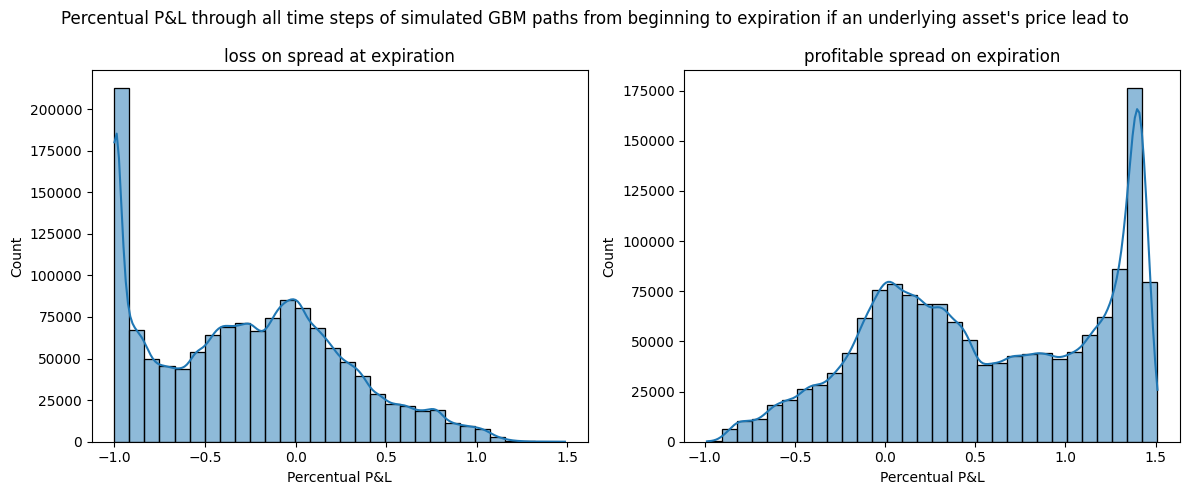

In [34]:
# ---- DISTRIBUTION OF PERCENTUAL P&L THROUGHOUT THE SPREADS' LIFESPAN TILL THE EXPIRATION ----
# Only for estimation of what percentual profits/losses might be hit before a spread ends up
# lossing or profitable on expiration.

lossing_at_exp_mask = spreads_perc_pnls_at_exp_final[:, -1] < 0
profiting_at_exp_mask = spreads_perc_pnls_at_exp_final[:, -1] > 0

spreads_lossing_at_exp = [
    all_spreads_pnls_excluding_s0_and_sT[sim][..., lossing_at_exp_mask[sim]]
    for sim in range(len(all_spreads_pnls_excluding_s0_and_sT))
]

spreads_profiting_at_exp = [
    all_spreads_pnls_excluding_s0_and_sT[sim][..., profiting_at_exp_mask[sim]]
    for sim in range(len(all_spreads_pnls_excluding_s0_and_sT))
]

# Flatten the data for visualisation
flattened_spreads_lossing_at_exp = np.concatenate(
    [arr.flatten() for arr in spreads_lossing_at_exp if arr.shape[1] > 0]
)

flattened_spreads_profiting_at_exp = np.concatenate(
    [arr.flatten() for arr in spreads_profiting_at_exp if arr.shape[1] > 0]
)

# Vizualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(flattened_spreads_lossing_at_exp, bins=30, kde=True, ax=axes[0])
axes[0].set_xlabel("Percentual P&L")
axes[0].set_title(f"loss on spread at expiration")

sns.histplot(flattened_spreads_profiting_at_exp, bins=30, kde=True, ax=axes[1])
axes[1].set_xlabel("Percentual P&L")
axes[1].set_title(f"profitable spread on expiration")

plt.suptitle("Percentual P&L through all time steps of simulated GBM paths from beginning to expiration if an underlying asset's price lead to")

plt.tight_layout()
plt.show()

FUTURE MODELLING OBJECTIVE 3:<br>
CONSIDERING A SPECIFIC TIME WINDOW OF CALL DEBIT SPREAD LIFESPAN AND CALCULATING THE EXPECTED RETURN/LOSS WHEN A CALL DEBIT SPREAD IS CLOSED AT PARTICULAR PERCENTUAL PROFIT OR LOSS THRESHOLD

The first-passage problem is approached here, i.e., what happens first, is hit a particular percentual loss or a particular percentual profit?

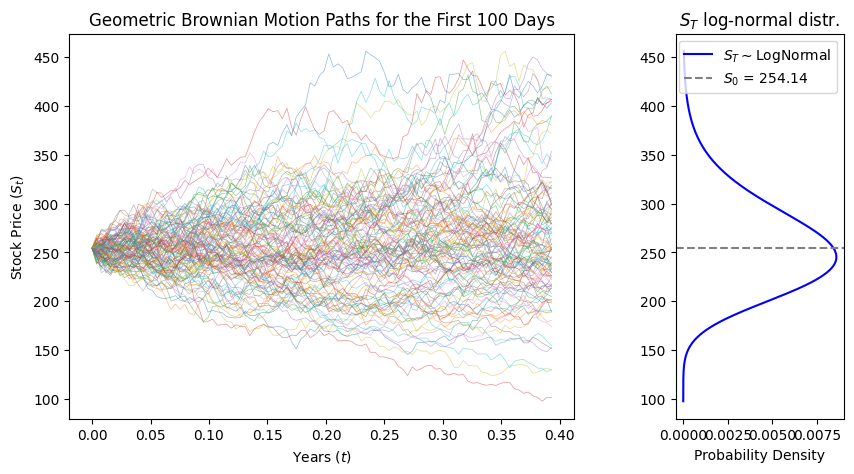

In [35]:
# First 100 simulated days
particular_length_tt = tt[:100]
particular_length_St = St[:100]

# Log-normal probabilities
particular_length_mu = np.mean(np.log(particular_length_St))
particular_length_sigma = np.std(np.log(particular_length_St))
particular_length_s = np.linspace(particular_length_St.min(), particular_length_St.max(), 1000)
particular_length_pdf = lognorm.pdf(
    particular_length_s, s=particular_length_sigma, scale=np.exp(particular_length_mu) 
    )

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, width_ratios=[3, 1], wspace=0.3)

ax0 = fig.add_subplot(gs[0])
ax0.plot(particular_length_tt, particular_length_St, lw=0.5, alpha=0.5)
ax0.set_xlabel("Years $(t)$")
ax0.set_ylabel("Stock Price $(S_t)$")
ax0.set_title("Geometric Brownian Motion Paths for the First 100 Days")

ax1 = fig.add_subplot(gs[1])
ax1.plot(particular_length_pdf, particular_length_s, label=r'$S_T \sim \mathrm{LogNormal}$', color='blue')
ax1.set_title("$S_T$ log-normal distr.")
ax1.axhline(S0, linestyle='--', color='gray', label=f"{r'$S_0$'} = {S0}")
#ax1.axhline(K, linestyle="-.", color="red", label=f"K = {K}")
ax1.legend()
ax1.set_xlabel("Probability Density")

min_price, max_price = ax0.get_ylim()
ax1.set_ylim(min_price, max_price)

plt.tight_layout()
plt.show()

In [36]:
# While looking for the first 
all_spreads_pnls_list = np.array(spreads_perc_pnls_at_exp_final) # array: simulations -> GBM time steps -> spreads
n_sim, n_steps, n_spreads = all_spreads_pnls_list.shape

# 
percentual_profit = np.full((n_sim, n_spreads), -1, dtype=int) # array: simulations -> spreads
percentual_loss = np.full((n_sim, n_spreads), -1, dtype=int) # array: simulations -> spreads

for t in range(n_steps):
    pnl_at_t = all_spreads_pnls_list[:, t, :] # all simulations -> all spreads for time step given by t

    # These create Boolean masks, i.e., arrays of True/False values, with structure copying
    # percentual_profit/percentual_loss arrays (simulations -> spreads) that identify exceeding of given
    # percentual thresholds of profits or losses for each simulation and all spreads in that simulation.
    # This is to happen at each time t, i.e., each step of GBM path
    # The code captures only the first time the condition is met for each spread in each simulation because
    # only spreads that haven't met the profit/loss condition, i.e., still marked as -1, are updated. Once
    # a value is set, e.g., from -1 to some step t, it's never overwritten, because it no longer satisfies
    # percentual_profit == -1
    not_found_profit = (percentual_profit == -1) & (pnl_at_t >= PREMATURE_PERC_PROFIT)
    not_found_loss = (percentual_loss == -1) & (pnl_at_t <= PREMATURE_PERC_LOSS)
    percentual_profit[not_found_profit] = t
    percentual_loss[not_found_loss] = t



Probability of loss occuring first is: 7.8818%
Probability of profit occuring first is: 20.2%
Probability of no particular percentual profit or loss is: 22.9182%


<Axes: title={'center': "Distribution of given percentual profits and losses throughout the spreads' lifespan"}, ylabel='Density'>

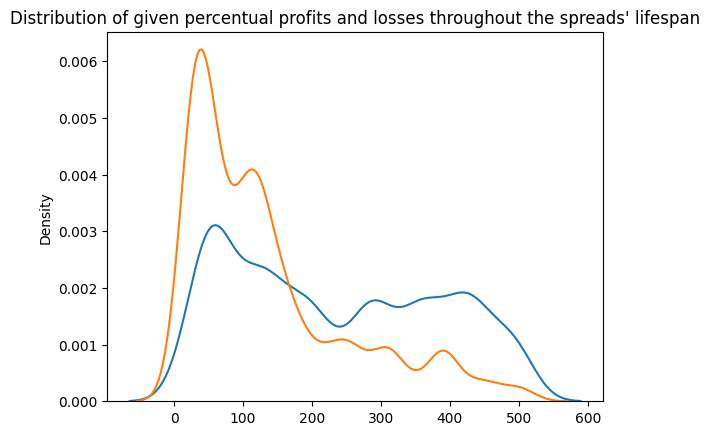

In [37]:
first_event = np.zeros_like(percentual_profit)

mask_profit_first = ((percentual_profit != -1) & (percentual_profit <= 100) &
    (
        (percentual_loss == -1) | 
        (percentual_profit < percentual_loss)
    )
)


mask_loss_first = ((percentual_loss != -1) & (percentual_loss <= 100) &
    (
        (percentual_profit == -1) | 
        (percentual_loss < percentual_profit)
    )
)


first_event[mask_profit_first] = 1
first_event[mask_loss_first] = -1   

first_event_reshaped = first_event.reshape(-1)
prob_of_loss_happening_first = round((len(first_event[first_event == -1]) / len(first_event)), 4)
prob_of_profit_happening_first = round((len(first_event[first_event == 1]) / len(first_event)), 4)
prob_of_nothing_happening = round((len(first_event[first_event == 0]) / len(first_event)), 4)
print(f"Probability of loss occuring first is: {prob_of_loss_happening_first}%")
print(f"Probability of profit occuring first is: {prob_of_profit_happening_first}%")
print(f"Probability of no particular percentual profit or loss is: {prob_of_nothing_happening}%")

valid_loss_days = percentual_loss[percentual_loss != -1]
valid_profit_days = percentual_profit[percentual_profit != -1]

plt.title("Distribution of given percentual profits and losses throughout the spreads' lifespan")
sns.kdeplot(data=valid_loss_days)
sns.kdeplot(data=valid_profit_days)

FUTURE MODELLING OBJECTIVE 4:<br>
CONSIDERING THE LEFT CALL DEBIT SPREADS THROUGHOUT ALL GBM SIMULATIONS WHICH HAVEN'T BEEN CLOSED DUE TO NOT HITTING THE PARTICULAR PERCENTUAL P&L WITHIN THE SPECIFIED TIME WINDOW AND AS DRIFT AND VARIANCE SHOULD HAVE ALREADY TAKEN AN EFFECT, FIRST-PASSAGE PROBLEM FOR PARTICULAR PERCENTUAL LOSS BEFORE EXERCISING THE PROFITABLE ONES IS ADDRESSED.

In [38]:
# True if percentual_profit == -1, i.e., spreads have never achieved a given partial profit
# True if percentual_profit >= 100, i.e., given percentual profit appeared beyond 100 days
# If True, keep such a spread
keep_later_profits_mask = (percentual_profit == -1) | (percentual_profit > 100)
# True if percentual_loss == -1, i.e., spreads have never achieved a given partial loss
# True if percentual_loss >= 100, i.e., given percentual loss appeared beyond 100 days
# If True, keep such a spread
keep_later_losses_mask = (percentual_loss == -1) | (percentual_loss > 100)

# Filtering out paths of spreads with early percentual profits and losses at once
filtering_out_early_profits_and_losses = [
    spreads_perc_pnls_at_exp_final[i, :, keep_later_profits_mask[i] & keep_later_losses_mask[i]]
    for i in range(spreads_perc_pnls_at_exp_final.shape[0])
]

# Cutting off the first 100 days so only the rest is considered and first-passage problem can be
# solved again
beyond_100_days_spreads = []
beyond_100_days_thetas = []
for i in range(len(filtering_out_early_profits_and_losses)):
    if filtering_out_early_profits_and_losses[i].shape[0] != 0:
        beyond_100_days_spreads.append(
            [arr[100:] for arr in filtering_out_early_profits_and_losses[i][:]]
        )

# (Spreads from all simulations, time steps) -> Count of spreads from all simulations is
# equal to 
beyond_100_days_spreads_flattened = [arr for sim in beyond_100_days_spreads for arr in sim]

FUTURE MODELLING OBJECTIVE 5:<br>
USING MONTE CARLO SIMULATION, SIMULATING OPENING VARIOUS CALL DEBIT SPREADS AND THEIR CLOSING BASED ON PREVIOUSLY DEFIND CONDITIONS. THE PRODUCT IS EXPECTED RETURN/LOSS BASED ON MAX PROFITS/LOSSES OF CALL DEBIT SPREADS AVAILABLE


In [39]:
simulations_count = 1000
positions_count = 3
strategy_expected_returns_list = []


for _ in range(simulations_count):

    simulated_pnl = []
    simulated_costs = []

    for _ in range(positions_count):
        simulation = np.random.randint(0, n_sim)
        spread = np.random.randint(0, n_spreads)
        # If value is 1 in first_event array, spread is profitable within the early period
        if first_event[simulation][spread] == 1:
            profit_in_usd = PREMATURE_PERC_PROFIT * spreads["max_profit"].iloc[spread]
            simulated_pnl.append(profit_in_usd)
            simulated_costs.append(spreads["spread_cost"].iloc[spread])
        # If value is -1 in first_event array, spread is lossing within the early period
        """
        if first_event[simulation][spread] == -1:
            loss_in_usd = PREMATURE_PERC_LOSS * spreads["max_loss"].iloc[spread]
            simulated_pnl.append(loss_in_usd)
            simulated_costs.append(spreads["spread_cost"].iloc[spread])
        """
        # If value is 0 in first_event array, it means that a spread isn't profitable/lossing within the
        # early stage, so the time steps beyond this early stage are considered
        if first_event[simulation][spread] == 0 | first_event[simulation][spread] == -1:
            expiring_spread_pnl = spreads_perc_pnls_at_exp_final[simulation, -1, spread]
            if expiring_spread_pnl == -1:
                #loss_in_usd = -spreads["max_loss"].iloc[spread]
                loss_in_usd = PREMATURE_PERC_LOSS * spreads["spread_cost"].iloc[spread]
                simulated_pnl.append(loss_in_usd)
                simulated_costs.append(spreads["spread_cost"].iloc[spread])
            else:
                profit_in_usd = expiring_spread_pnl * spreads["max_profit"].iloc[spread]
                simulated_pnl.append(profit_in_usd)
                simulated_costs.append(spreads["spread_cost"].iloc[spread])

    try:
        strategy_expected_return = round((sum(simulated_pnl) / sum(simulated_costs)) * 100, 2)
        strategy_expected_returns_list.append(strategy_expected_return)
    except Exception:
        continue


#strategy_expected_return = (sum(simulated_pnl) / sum(simulated_costs)) * 100
#print(f"P&L while closing the spread prematuraly within the early period or at expiration: {round(sum(simulated_pnl), 2)}")
#print(f"Return on simulated spreads is: {round(strategy_expected_return, 2)}%")

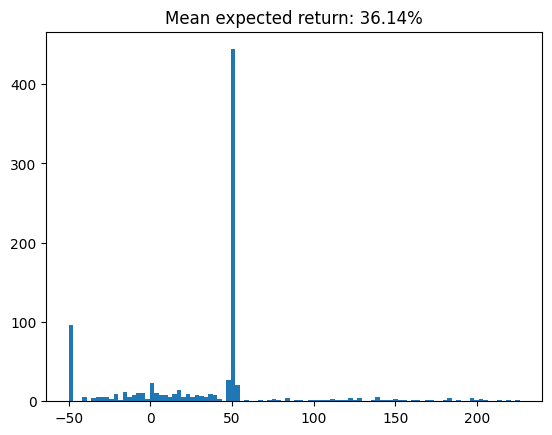

In [40]:
plt.hist(strategy_expected_returns_list, bins=100)
plt.title(f"Mean expected return: {round(np.mean(strategy_expected_returns_list), 2)}%")
plt.show()

#strategy_expected_returns_list

NOTES (to future modelling via GBM simulation):<br>
Simulation was made without any specific consideration of other quantitative metrics, i.e., where the price of an underlying asset and moving averages levels are, so the probabilities basically apply to Call Debit Spreads opened at any point. Even though the strategy is back-tested on events when underlying asset's price is between 50-days and 100-days Moving Averages and 50-days MA is above the 100-days one, drift and variance computed on long time period prices shouldn't be influenced by 

As geometric Brownian Motion uses for simulation only drift and variance computed from used period of prices, price level in respect to levels of 50-days and 100-days Moving Averages used in back-testing, shouldn't play role in computed probabilities, so even even though the simulation was made without any specific consideration of other quantitative metrics, the probabilities basically apply to Call Debit Spreads opened at any point.

***************************************************************************************************************************************************

---- BACK-TESTING THE STRATEGY ON HISTORICAL DATA ----<br>

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, broadcast
from pyspark.sql.types import StructType, StructField, DateType, DoubleType, StringType, ArrayType
from pyspark.sql.window import Window
from pyspark.sql import functions as F

In [8]:
def set_expiration_date(date):
    # The expiration date is in two years from a selected date on which a Call Debit Spread position would be opened.
    # The expiration date is set YEARS_TO_EXP in the future which is useful for pricing the options using Black Scholes,
    # but if we want to find out whether the Call Debit Spread is profitable or not at expiration, we need to know the
    # price of an underlying asset. The data DataFrame contains prices of an underlying asset on trading days, but if a calendar
    # day defined by YEARS_TO_EXP value isn't the trading one, e.g., it's a weekend day or a holiday day, we need to adjust
    # this day of expiration to the closest trading one.
    day_deduction = 0
    while data[data["Date"] == (date + relativedelta(years=YEARS_TO_EXP, days=day_deduction))].shape[0] == 0:
        day_deduction -= 1
    expiration_date = (date + relativedelta(years=YEARS_TO_EXP, days=day_deduction))
    return expiration_date

In [9]:
# SETTING UP PYSPARK for faster data processing

os.environ["PYSPARK_PYTHON"] = "/opt/homebrew/bin/python3.11"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/homebrew/bin/python3.11"

spark = (
    SparkSession.builder
    .appName("CallDebitSpread")
    .config("spark.driver.memory", "8g")
    .config("spark.pyspark.python", "/opt/homebrew/bin/python3.11") 
    .config("spark.pyspark.driver.python", "/opt/homebrew/bin/python3.11")  
    .getOrCreate()
    )
spark.sparkContext.setLogLevel("ERROR")

print(spark)

print("Driver Python:", spark.conf.get("spark.pyspark.driver.python"))
print("Worker Python:", spark.conf.get("spark.pyspark.python"))

print("PYSPARK_PYTHON:", os.environ.get("PYSPARK_PYTHON"))
print("PYSPARK_DRIVER_PYTHON:", os.environ.get("PYSPARK_DRIVER_PYTHON"))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/16 10:05:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Driver Python: /opt/homebrew/bin/python3.11
Worker Python: /opt/homebrew/bin/python3.11
PYSPARK_PYTHON: /opt/homebrew/bin/python3.11
PYSPARK_DRIVER_PYTHON: /opt/homebrew/bin/python3.11


In [10]:
selected_dates_backtest = \
data[
    (data["Date"] <= (data["Date"].iloc[0] - timedelta(days=YEARS_TO_EXP * 365))) &
    (data["Date"] > (data["Date"].iloc[-1] + timedelta(days=30))) &
    (data["50_day_MA"] > data["100_day_MA"]) &
    (data["Close"] > data["100_day_MA"]) &
    (data["Close"] < data["50_day_MA"])
]

In [13]:
data

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Adjustment_factor,50_day_MA,100_day_MA,Log_return,Volatility,Risk-free Rate
2513,2513,2025-08-14,250.360,255.06,250.05,254.140000,5315659.0,1.0,237.9714,214.0817,0.001024,0.217457,0.0429
2512,2512,2025-08-13,252.133,254.10,251.04,253.880000,6022389.0,1.0,237.1610,213.5341,0.014761,0.217599,0.0424
2511,2511,2025-08-12,244.240,250.38,242.71,250.160000,10096074.0,1.0,236.2440,213.0102,0.031470,0.212426,0.0429
2510,2510,2025-08-11,243.780,246.51,241.95,242.410000,4127866.0,1.0,235.3396,212.5397,-0.001896,0.182852,0.0427
2509,2509,2025-08-08,241.005,243.18,240.29,242.870000,5301269.0,1.0,234.6732,212.1303,0.008394,0.185739,0.0427
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,4,2015-08-21,79.700,80.93,78.53,26.176667,1379888.0,3.0,NaN,NaN,-0.027753,NaN,0.0205
3,3,2015-08-20,82.980,83.02,80.71,26.913333,892456.0,3.0,NaN,NaN,-0.038272,NaN,0.0209
2,2,2015-08-19,84.830,84.85,83.34,27.963333,487024.0,3.0,NaN,NaN,-0.009019,NaN,0.0212
1,1,2015-08-18,86.150,86.16,84.52,28.216667,407197.0,3.0,NaN,NaN,-0.019073,NaN,0.0220


In [16]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)

selected_dates_backtest = selected_dates_backtest.sort_values(by="Date", ascending=False)
data = data.sort_values(by="Date", ascending=False)
spreads = []

for i in range(0, selected_dates_backtest.shape[0]):
    date = selected_dates_backtest["Date"].iloc[i]

    forecast, confidential_boundary = model.model(data[data["Date"] <= date], parameters)
    atm_strike_price = round(forecast[0])
    strike_list_lower_boundary = round(confidential_boundary[0][0])
    strike_list_upper_boundary = round(confidential_boundary[0][1])
    strike_prices_list = [strike for strike in range(strike_list_lower_boundary, strike_list_upper_boundary + 1)]

    #historical_volatility_data = data[(data["Date"] >= date) & (data["Date"] <= date + pd.DateOffset(years=1))].sort_values(by="Date", ascending=True)
    #historical_volatility_data["log_returns"] = np.log(historical_volatility_data["Close"] / historical_volatility_data["Close"].shift(1))
    #historical_volatility_data["log_returns_squared"] = historical_volatility_data["log_returns"] ** 2
    sigma_historical = data.loc[data["Date"] == date, "Volatility"].item()
    risk_free_rate = data.loc[data["Date"] == date, "Risk-free Rate"].item()

    strike_price_chain = {}
    strike_price_chain = {
        "strike": strike_prices_list,
        "price": np.full(len(strike_prices_list), None),
        "implied_volatility": np.full(len(strike_prices_list), sigma_historical)
    }
    strike_price_chain = pd.DataFrame(strike_price_chain)

    # Calculating price of options in a strike price chain
    strike_price_chain["price"] = strike_price_chain.apply(
        lambda row: calculate_call_option_price(
            data.loc[data["Date"] == date, "Close"].item(), # Stock price (scalar)
            row["strike"],
            row["implied_volatility"], # Implied volatility (scalar)
            YEARS_TO_EXP,
            risk_free_rate
        ),
        axis=1 
    )

    for i, long_call in strike_price_chain.iterrows():
        for j, short_call in strike_price_chain.iloc[i+1:].iterrows():
            spread_cost = long_call["price"] - short_call["price"]
            max_profit = (short_call["strike"] - long_call["strike"]) - spread_cost

            spreads.append({
                "date": date,
                "expiration_date": set_expiration_date(date),
                "long_strike": long_call["strike"],
                "short_strike": short_call["strike"],
                "long_price": long_call["price"],
                "short_price": short_call["price"],
                "spread_cost": spread_cost,
                "max_profit": max_profit,
                "max_loss": spread_cost,
                "expiration_p/l": None,
                "expiration_perc_profit": None,
                "premature_perc_profit": None,
                "premature_day": None,
                "trading_days": None
            })
    

spreads = pd.DataFrame(spreads)

"""
spreads = spreads.merge(data[["Date", "Close", "Risk-free Rate"]], left_on="date", right_on="Date", how="left")

spreads = spreads[
    (spreads["long_strike"] < spreads["short_strike"]) &
    (spreads["short_strike"] > spreads["Close"]) # Only OTM spreads are considered
]
"""
#spreads = spreads[(spreads["max_profit"] > spreads["max_loss"])]

spreads
    

""


In [58]:
schema = StructType([
    StructField("date", DateType(), True),
    StructField("expiration_date", DateType(), True),
    StructField("long_strike", DoubleType(), True),
    StructField("short_strike", DoubleType(), True),
    StructField("long_price", DoubleType(), True),
    StructField("short_price", DoubleType(), True),
    StructField("spread_cost", DoubleType(), True),
    StructField("max_profit", DoubleType(), True),
    StructField("max_loss", DoubleType(), True),
    StructField("expiration_p/l", StringType(), True),  # Object type → String
    StructField("%_profit", StringType(), True),  # Object type → String
    StructField("trading_days", ArrayType(DateType()), True)
])

# Convert Pandas DataFrame to Spark DataFrame
spreads_sdf = spark.createDataFrame(spreads, schema=schema)

# Transforming Pandas DataFrame to Spark DataFrame and creating DataFrame of unique trading days
data_spark = spark.createDataFrame(data)
data_dates = data_spark.select("date").distinct()

# DataFrame of spreads and DataFrame of available trading days both contain variable date, so they needed to be remained not to be
# mismatched with each other
spreads_sdf = spreads_sdf.withColumnRenamed("date", "spread_date")
data_dates = data_dates.withColumnRenamed("date", "trading_date")

valid_trading_dates = spreads_sdf.join(
    data_dates,
    (col("spread_date") <= col("trading_date")) & (col("trading_date") <= col("expiration_date")),
    "inner"
).groupBy(
    "spread_date",
    "expiration_date"
).agg(
    collect_list("trading_date").alias("valid_trading_dates")
)

valid_trading_dates = valid_trading_dates.withColumn(
    "valid_trading_dates",
    F.expr("array_distinct(valid_trading_dates)")
)

# Result is a DataFrame with list of all trading days between days of opening a Call Debit Spread position and expiration date
# Trading days are given by data DataFrame obtained from Yahoo Finance 
valid_trading_dates = valid_trading_dates.toPandas()

spark.stop() # Stop Pyspark app since I won't need it further


In [59]:
unq_data_exp_comb = spreads[["date", "expiration_date"]].drop_duplicates() # Unique combination of dates and expiration dates

# For each unique combination of date and expiration date, list of trading dates between the given date and expiration date from
# valid_trading_dates DataFrame is extracted and is inserted into trading_days column in spreads DataFrame of all rows where
# given date and expiration date match
for date, exp_date in zip(unq_data_exp_comb["date"], unq_data_exp_comb["expiration_date"]):

    valid_trading_dates_list = valid_trading_dates.loc[
        (pd.to_datetime(valid_trading_dates["spread_date"]) == date) & (pd.to_datetime(valid_trading_dates["expiration_date"]) == exp_date),
        "valid_trading_dates"
    ].values[0]

    matching_spreads = spreads.loc[(spreads["date"] == date) & (spreads["expiration_date"] == exp_date)]
    for index in matching_spreads.index:
        spreads.at[index, "trading_days"] = valid_trading_dates_list

spreads["trading_days"] = spreads["trading_days"].apply(sorted)

spreads



,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,expiration_perc_profit,premature_perc_profit,premature_day,trading_days,Date,Close,Risk-free Rate
3,2023-08-04,2025-08-04,178.0,182.0,31.422250,29.370709,2.051541,1.948459,2.051541,None,None,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
4,2023-08-04,2025-08-04,178.0,183.0,31.422250,28.874068,2.548181,2.451819,2.548181,None,None,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
5,2023-08-04,2025-08-04,178.0,184.0,31.422250,28.383880,3.038370,2.961630,3.038370,None,None,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
6,2023-08-04,2025-08-04,178.0,185.0,31.422250,27.900118,3.522132,3.477868,3.522132,None,None,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
7,2023-08-04,2025-08-04,178.0,186.0,31.422250,27.422753,3.999497,4.000503,3.999497,None,None,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,2016-09-09,2018-09-07,26.0,27.0,2.478506,2.024716,0.453790,0.546210,0.453790,None,None,None,None,"[2016-09-09 00:00:00, 2016-09-12 00:00:00, 201...",2016-09-09,25.7825,0.0167
1843,2016-05-27,2018-05-25,24.0,26.0,3.940081,2.985786,0.954295,1.045705,0.954295,None,None,None,None,"[2016-05-27 00:00:00, 2016-05-31 00:00:00, 201...",2016-05-27,25.0875,0.0185
1844,2016-05-27,2018-05-25,25.0,26.0,3.437167,2.985786,0.451381,0.548619,0.451381,None,None,None,None,"[2016-05-27 00:00:00, 2016-05-31 00:00:00, 201...",2016-05-27,25.0875,0.0185
1846,2016-05-26,2018-05-25,24.0,26.0,4.026142,3.077396,0.948745,1.051255,0.948745,None,None,None,None,"[2016-05-26 00:00:00, 2016-05-27 00:00:00, 201...",2016-05-26,25.1025,0.0183


PROFIT/LOSS AT EXPIRATION

There are only three scenarions:
$$\text{Scenario 1, when: } S_{\text{asset's price at expiration}} < K_{\text{strike of call long}} \text{, then } \text{\small (Premium Paid for Long Call - Premium Received for Short Call)}$$
$$\text{Scenario 2, when: } K_{\text{strike of long call}} <= S_{\text{asset's price at expiration}} < K_{\text{strike of short call}} \text{, then } (S_{\text{current asset's price}} - K_{\text{strike of long call}}) - \text{\small Net Premium Paid}$$
$$\text{Scenario 3, when: } K_{\text{strike of short call}} < S_{\text{asset's price at expiration}} \text{, then } (S_{\text{asset's price at expiration}} - K_{\text{strike of call long}}) - \text{\small Net Premium Paid}$$

In the case of the 1st scenario, long call option as well as short call one expired worthless, so the loss on paid premium is realized, while profit on premium of written call is gained. However, as long call was at the time of purchase ITM or closer to ITM than written call, higher
premium was paid than received, so the maximum loss given by the difference between paid and received premiums is realized.

In the case of second scenario, the premium for a short call is received and long call expired In The Money, so the profit given by difference between asset's actual price and long call strike price can be realized. The profit is given by this difference, i.e., with what discount the asset can be bought. If this profit isn't significant enough to cover the premium of a long call, even after receiving premium for short call, loss is realized.

In the case of the 3rd scenario, price of an asset at expiration is higher than strike price of a short call which means that it is also higher than than strike price of a long call. Profit at expiration is therefore given by exercising the long call option and receiving profit between asset's actual price and strike price while loss given by short call expiring In The Money must be covered.

PROGRAM FLOW

For each nested DataFrame and its key (selected date on which the postion of call debit spread was open), calculate P/L on expiration (for the closest trading day) accoring to the three scenarios presente above.

In [60]:
for index, spread in spreads.iterrows():
    
    expiration_date = spread["expiration_date"]

    asset_price_at_expiration = data.loc[data["Date"] == expiration_date, "Close"].item()

    #sigma_at_expiration = data.loc[data["Date"] == expiration_date, "Volatility"]

    if asset_price_at_expiration > spread["short_strike"]:
        spreads.loc[index, "expiration_p/l"] = 1 # max profit
        spreads.loc[index, "expiration_perc_profit"] = (spread["short_strike"] - spread["long_strike"] - spread["spread_cost"]) / spread["spread_cost"]
    elif asset_price_at_expiration < spread["long_strike"]:
        spreads.loc[index, "expiration_p/l"] = -1 # max_loss
        spreads.loc[index, "expiration_perc_profit"] = -1
    else:
        exp_pnl_amount = asset_price_at_expiration - spread["long_strike"] - spread["spread_cost"]
        spreads.loc[index, "expiration_p/l"] = 0 # partial p/l at expiration
        spreads.loc[index, "expiration_perc_profit"] = exp_pnl_amount / spread["spread_cost"]

In [61]:
max_profit_at_exp = spreads[spreads["expiration_p/l"] == 1].shape[0]
max_loss_at_exp = spreads[spreads["expiration_p/l"] == -1].shape[0]
partial_profit_at_exp = spreads[~spreads["expiration_p/l"].isin([-1, 1]) & (spreads["expiration_perc_profit"] > 0)].shape[0]
partial_loss_at_exp = spreads[~spreads["expiration_p/l"].isin([-1, 1]) & (spreads["expiration_perc_profit"] < 0)].shape[0]
all_events = spreads.shape[0]

print(f"Probability of achieving max profit: {round(max_profit_at_exp / all_events, 4)}")
print(f"Probability of achieving max loss: {round(max_loss_at_exp / all_events, 4)}")
print(f"Probability of partial profit: {round(partial_profit_at_exp / all_events, 4)}")
print(f"Probability of partial loss: {round(partial_loss_at_exp / all_events, 4)}")

Probability of achieving max profit: 1.0
Probability of achieving max loss: 0.0
Probability of partial profit: 0.0
Probability of partial loss: 0.0


In [62]:
spreads

,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,expiration_perc_profit,premature_perc_profit,premature_day,trading_days,Date,Close,Risk-free Rate
3,2023-08-04,2025-08-04,178.0,182.0,31.422250,29.370709,2.051541,1.948459,2.051541,1,0.949754,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
4,2023-08-04,2025-08-04,178.0,183.0,31.422250,28.874068,2.548181,2.451819,2.548181,1,0.962184,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
5,2023-08-04,2025-08-04,178.0,184.0,31.422250,28.383880,3.038370,2.961630,3.038370,1,0.974743,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
6,2023-08-04,2025-08-04,178.0,185.0,31.422250,27.900118,3.522132,3.477868,3.522132,1,0.987432,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
7,2023-08-04,2025-08-04,178.0,186.0,31.422250,27.422753,3.999497,4.000503,3.999497,1,1.000252,None,None,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.9900,0.0405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,2016-09-09,2018-09-07,26.0,27.0,2.478506,2.024716,0.453790,0.546210,0.453790,1,1.203665,None,None,"[2016-09-09 00:00:00, 2016-09-12 00:00:00, 201...",2016-09-09,25.7825,0.0167
1843,2016-05-27,2018-05-25,24.0,26.0,3.940081,2.985786,0.954295,1.045705,0.954295,1,1.095788,None,None,"[2016-05-27 00:00:00, 2016-05-31 00:00:00, 201...",2016-05-27,25.0875,0.0185
1844,2016-05-27,2018-05-25,25.0,26.0,3.437167,2.985786,0.451381,0.548619,0.451381,1,1.215425,None,None,"[2016-05-27 00:00:00, 2016-05-31 00:00:00, 201...",2016-05-27,25.0875,0.0185
1846,2016-05-26,2018-05-25,24.0,26.0,4.026142,3.077396,0.948745,1.051255,0.948745,1,1.108047,None,None,"[2016-05-26 00:00:00, 2016-05-27 00:00:00, 201...",2016-05-26,25.1025,0.0183


In [63]:
def pl_before_expiration(row):

    nth_day = 0

    trading_days_list = row["trading_days"]
    for day in trading_days_list:
        price = data.loc[data["Date"] == day, "Close"].item()
        sigma = data.loc[data["Date"] == day, "Volatility"].item()
        r = data.loc[data["Date"] == day, "Risk-free Rate"].item()
        time_to_exercise = len(trading_days_list[trading_days_list.index(day):]) / (252 * 2)


        long_call_price = calculate_call_option_price(price, row["long_strike"], sigma, time_to_exercise, r)
        short_call_price = calculate_call_option_price(price, row["short_strike"], sigma, time_to_exercise, r)

        call_debit_spread_price = long_call_price - short_call_price

        percentual_pnl = (call_debit_spread_price - row["spread_cost"]) / row["spread_cost"]

        if percentual_pnl >= PREMATURE_PERC_PROFIT:
            return nth_day, percentual_pnl
        
        if percentual_pnl <= PREMATURE_PERC_LOSS:
            return nth_day, percentual_pnl
        
        nth_day += 1

    return None, None

results = spreads.apply(pl_before_expiration, axis=1)

In [64]:
results

3       (78, 0.3698055023380187)
4       (78, 0.3654051255873762)
5       (78, 0.3607800967575209)
6       (78, 0.3559353013829393)
7       (78, 0.3508760591022603)
                  ...           
1841    (21, 0.4077629914495053)
1843    (61, 0.5267360196782221)
1844    (61, 0.5039980553029508)
1846    (62, 0.5356670633973196)
1847    (62, 0.5108273152315668)
Length: 1506, dtype: object

In [65]:
results_df = pd.DataFrame(results.tolist(), columns=["premature_day", "premature_perc_profit"])

spreads[["premature_day", "premature_perc_profit"]] = results_df

spreads[spreads["premature_day"] <= 100]

,date,expiration_date,long_strike,short_strike,long_price,short_price,spread_cost,max_profit,max_loss,expiration_p/l,expiration_perc_profit,premature_perc_profit,premature_day,trading_days,Date,Close,Risk-free Rate
3,2023-08-04,2025-08-04,178.0,182.0,31.422250,29.370709,2.051541,1.948459,2.051541,1,0.949754,0.355935,78.0,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.99,0.0405
4,2023-08-04,2025-08-04,178.0,183.0,31.422250,28.874068,2.548181,2.451819,2.548181,1,0.962184,0.350876,78.0,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.99,0.0405
5,2023-08-04,2025-08-04,178.0,184.0,31.422250,28.383880,3.038370,2.961630,3.038370,1,0.974743,0.365768,78.0,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.99,0.0405
6,2023-08-04,2025-08-04,178.0,185.0,31.422250,27.900118,3.522132,3.477868,3.522132,1,0.987432,0.361222,78.0,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.99,0.0405
7,2023-08-04,2025-08-04,178.0,186.0,31.422250,27.422753,3.999497,4.000503,3.999497,1,1.000252,0.356451,78.0,"[2023-08-04 00:00:00, 2023-08-07 00:00:00, 202...",2023-08-04,181.99,0.0405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,2020-09-17,2022-09-16,110.0,111.0,34.290470,33.941914,0.348556,0.651444,0.348556,1,1.868981,0.407763,21.0,"[2020-09-17 00:00:00, 2020-09-18 00:00:00, 202...",2020-09-17,110.34,0.0069
1502,2020-09-17,2022-09-16,110.0,112.0,34.290470,33.597563,0.692907,1.307093,0.692907,1,1.886389,0.526736,61.0,"[2020-09-17 00:00:00, 2020-09-18 00:00:00, 202...",2020-09-17,110.34,0.0069
1503,2020-09-17,2022-09-16,110.0,113.0,34.290470,33.257360,1.033110,1.966890,1.033110,1,1.903852,0.503998,61.0,"[2020-09-17 00:00:00, 2020-09-18 00:00:00, 202...",2020-09-17,110.34,0.0069
1504,2020-09-17,2022-09-16,111.0,112.0,33.941914,33.597563,0.344351,0.655649,0.344351,1,1.90401,0.535667,62.0,"[2020-09-17 00:00:00, 2020-09-18 00:00:00, 202...",2020-09-17,110.34,0.0069


In [66]:
simulations_count = 1000
positions_count = 3

strategy_expected_returns_list_backtest = []

for _ in range(simulations_count):

    simulated_pnl = []
    simulated_costs = []
    sample_spreads = spreads.sample(n=positions_count, replace=True)

    for index, spread in sample_spreads.iterrows():

        if spread["premature_day"] <= 100:
            profit_in_usd = spread["premature_perc_profit"] * spread["max_profit"]
            simulated_pnl.append(profit_in_usd)
            simulated_costs.append(spread["spread_cost"])
        else:
            if spread["expiration_p/l"] == 1:
                simulated_pnl.append(spread["max_profit"])
            else:
                simulated_pnl.append(spread["spread_cost"])
            simulated_costs.append(spread["spread_cost"])

    try:
        strategy_expected_return = round((sum(simulated_pnl) / sum(simulated_costs)) * 100, 2)
        strategy_expected_returns_list_backtest.append(strategy_expected_return)
    except Exception:
        continue 
        


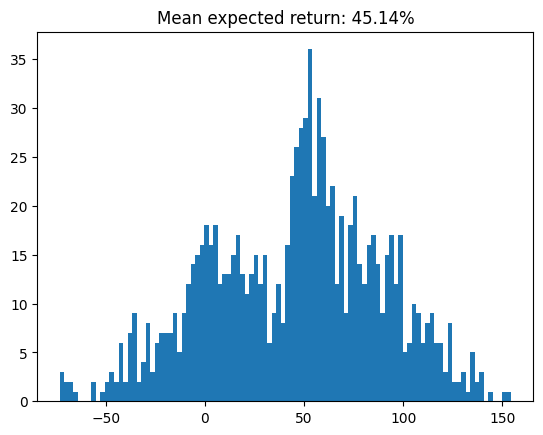

In [67]:
plt.hist(strategy_expected_returns_list_backtest, bins=100)
plt.title(f"Mean expected return: {round(np.mean(strategy_expected_returns_list_backtest), 2)}%")
plt.show()

NOTES:<br>